# Calculate Shortest Path and Generate OD Matrx
This notebook 
* attribute farms to road network nodes
* calculate all-pair shortest paths between farms and all potential digester locations
* save the OD matrix (C_ij) as dictionary {p0: {f0: distance, f1: distance}...}

In [34]:
from cflp_function import store_data_to_pickle
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.ops import nearest_points

In [2]:
%matplotlib inline

## 1. Farms to Nodes (QGIS)
Inputs:
* n - road network nodes (GeoDataFrame)
* farm - farm location points (GeoDataFrame)
* polygon_gdf - potential digester location polygons (GeoDataFrame)

In [24]:
n = gpd.read_file(r"./raster/clip_node.shp")
n.head()

,osmid,y,x,lon,lat,highway,geometry
0,391,6.852609e+06,749985.068617,6.737230,52.289324,motorway_junction,POINT (247106.336 478783.924)
1,421,6.852019e+06,750489.245723,6.741760,52.286082,motorway_junction,POINT (247422.054 478428.975)
2,422,6.853062e+06,749313.366809,6.731197,52.291813,NaN,POINT (246689.562 479053.139)
3,429,6.852456e+06,749798.452623,6.735554,52.288483,NaN,POINT (246993.714 478688.167)
4,430,6.853370e+06,749330.907112,0.000000,0.000000,NaN,POINT (246696.821 479241.477)


In [25]:
farm = gpd.read_file("./raster/clip_farm.shp")

In [29]:
print(n.crs, farm.crs)

EPSG:28992 EPSG:28992


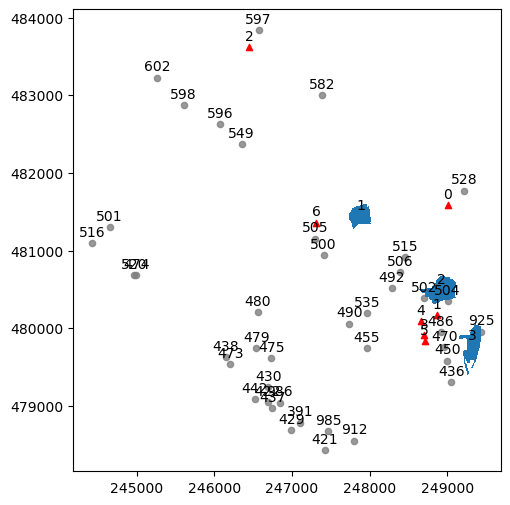

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))
farm.plot(ax=ax, markersize=20, marker='^', color='red')
n.plot(ax=ax, markersize=20, color='grey', alpha=0.8)
polygon_gdf.plot(ax=ax)
for x, y, idx in zip(farm.geometry.x, farm.geometry.y, farm.index.values):
    ax.annotate(idx, (x, y), textcoords='offset points', xytext=(0,5), ha='center')
# Annotate the points with their 'osmid' values
for x, y, osmid in zip(n.geometry.x, n.geometry.y, n['osmid']):
    ax.annotate(osmid, (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
for x, y, l in zip(polygon_gdf.centroid.x, polygon_gdf.centroid.y, polygon_gdf['Label']):
    ax.annotate(l, (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
plt.show()

In [51]:
# Find the nearest node for each farm
farm['closest_osmid'] = farm['geometry'].apply(
    lambda location: n.loc[n['geometry'] == nearest_points(location, n.unary_union)[1], 'osmid'].iloc[0]
)

In [54]:
polygon_gdf = gpd.read_file("./raster/suitable_polygons_gdf.shp")
polygon_gdf.head()

,Label,geometry
0,1,"MULTIPOLYGON (((247919.672 481598.031, 247969...."
1,2,"POLYGON ((248909.672 480668.031, 248969.672 48..."
2,3,"MULTIPOLYGON (((249359.672 480058.031, 249369...."


In [58]:
polygon_gdf['centroid'] = polygon_gdf['geometry'].centroid

In [59]:
# Find the nearest node in n for each centroid
polygon_gdf['closest_osmid'] = polygon_gdf['centroid'].apply(
    lambda centroid: n.loc[n['geometry'] == nearest_points(centroid, n.unary_union)[1], 'osmid'].iloc[0]
    # lambda centroid: n.loc[nearest_points(centroid, n.unary_union)[1].x, 'osmid']
)

In [26]:
# farm = pd.read_csv('./farm_mock.csv')
# farm.head()

In [15]:
potential_plant_location = pd.read_csv('./farm_cluster_mock_5.csv')
potential_plant_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [6]:
nearest_neighbor = pd.read_csv('./osm_network/nearest_neighbor.csv')
nearest_neighbor.head()

,InputID,TargetID,Distance
0,507920,528,286.673776
1,507950,845,811.058871
2,507953,655,949.973658
3,507962,855,1048.825422
4,507964,195,662.103623


Here I should be loading set P from another file, I meant the file that has the indices of nodes representing the potential digester location

In [12]:
nearest_neighbor_p = pd.read_csv('./osm_network/nearest_neighbor_p.csv')
nearest_neighbor_p.head()

,InputID,TargetID,Distance
0,6.870686,125,332.611924
1,6.554937,190,2133.896966
2,6.730518,134,702.733217
3,6.914234,975,1375.746295
4,6.664105,790,728.068584


In [13]:
nearest_neighbor = nearest_neighbor.rename(columns={"TargetID": "osmid"})

In [14]:
merged_df = pd.merge(farm, nearest_neighbor, how='left', left_on="IND_OBJ_NA", right_on='InputID')
merged_df.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3,InputID,osmid,Distance
0,0,6.765843,52.314139,507920,2454,957060.0,507920,528,286.673776
1,1,6.837249,52.425084,507950,9827,3832530.0,507950,845,811.058871
2,2,6.859361,52.386225,507953,8660,3377400.0,507953,655,949.973658
3,3,6.753483,52.434382,507962,2913,1136070.0,507962,855,1048.825422
4,4,6.484077,52.243620,507964,6488,2530320.0,507964,195,662.103623


In [16]:
potential_plant_location['osmid'] = nearest_neighbor_p['TargetID']

In [17]:
potential_plant_location

,x,y,count,osmid
0,6.870686,52.215190,25,125
1,6.554937,52.254895,25,190
2,6.730518,52.252885,42,134
3,6.914234,52.387401,18,975
4,6.664105,52.392622,32,790


## 2. Calculate OD Matrix
Inputs:
* Road network with farm information at nodes 
* Set of potential digester locations 

In [64]:
g = ox.load_graphml('./osm_network/G.graphml') 

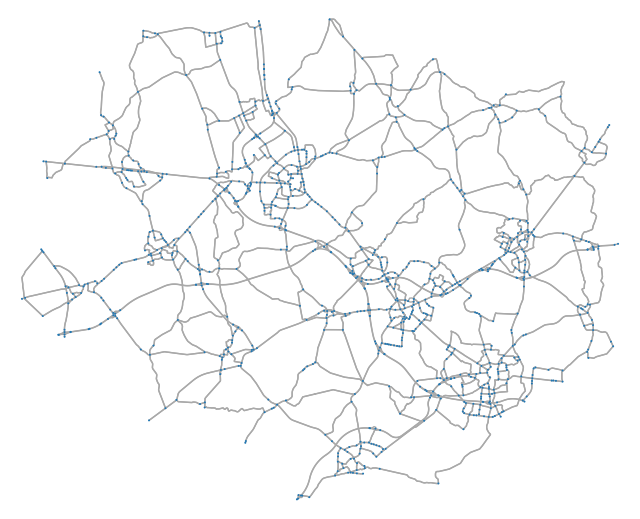

In [65]:
fig, ax = ox.plot_graph(g, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')

In [66]:
# n, e = ox.graph_to_gdfs(g)

In [68]:
orig = farm['closest_osmid'].unique().tolist()
orig

[528, 486, 597, 505]

In [69]:
dest = polygon_gdf['closest_osmid'].unique().tolist()
dest

[505, 504, 925]

In [70]:
# Initialize an empty OD matrix
od_matrix = {}

In [71]:
# Calculate shortest path between all pair orig (farm) and dest (potential location)
for origin in orig:
    od_matrix[origin] = {}
    for destination in dest:
        distance = nx.shortest_path_length(g, origin, destination, weight='length')
        od_matrix[origin][destination] = distance/1000 # convert from m to km
# {orig:{dest:distance, dest:distance....}}

In [73]:
farm['closest_osmid'].value_counts()

closest_osmid
486    4
528    1
597    1
505    1
Name: count, dtype: int64

In [74]:
# Initialize an empty nested dictionary
new_nested_dict = {}

# Create a new nested dictionary with DataFrame index as keys
for idx, row in farm.iterrows():
    osmid_value = row['closest_osmid']
    if osmid_value in od_matrix:
        new_nested_dict[idx] = od_matrix[osmid_value]

# {farm1:{dest:distance, dest:distance....}} # some nodes are the closest for more than 1 farms, so now we make sure the dictionary is with key of all farms and each take the 
# associated distances (i.e. some farms will have the same od to all dest)

In [76]:
new_nested_dict

{0: {505: 3.429940148821649, 504: 3.113911074421323, 925: 4.374809945381681},
 1: {505: 3.427462242787149, 504: 1.3655322069076914, 925: 2.610401261349747},
 2: {505: 5.34822224619812, 504: 8.52138839484582, 925: 9.782287265806179},
 3: {505: 3.427462242787149, 504: 1.3655322069076914, 925: 2.610401261349747},
 4: {505: 3.427462242787149, 504: 1.3655322069076914, 925: 2.610401261349747},
 5: {505: 3.427462242787149, 504: 1.3655322069076914, 925: 2.610401261349747},
 6: {505: 0.0, 504: 3.1731661486477014, 925: 4.4340650196080595}}

In [88]:
# Transform the nested dictionary such that the OD matrix is a dictionary with dest as main keys {dest1{farm1:distance, farm2:distance.....}}
transportation_cost = {}
for outer_key, inner_dict in new_nested_dict.items():
    for inner_key, value in inner_dict.items():
        if inner_key not in transportation_cost:
            transportation_cost[inner_key] = {outer_key: value}
        else:
            transportation_cost[inner_key][outer_key] = value

In [83]:
# Switch key of OD matrix from osmid to numbers 
transportation_cost = {i: transportation_cost[key] for i, key in enumerate(transportation_cost)}

In [93]:
cost_per_km = 0.69

# Function to multiply values in nested dictionary by 0.69
def multiply_dict_values(d, cost_per_km = cost_per_km):
    for k, v in d.items():
        if isinstance(v, dict):
            multiply_dict_values(v)
        else:
            d[k] = v * cost_per_km

In [94]:
# Multiply all values in the nested dictionary by 0.69
multiply_dict_values(transportation_cost)

In [95]:
# Print the new nested dictionary
print("New Nested Dictionary:")
for key, value in transportation_cost.items():
    print(f"{key}: {value}")

New Nested Dictionary:
505: {0: 2.3666587026869377, 1: 2.3649489475231324, 2: 3.6902733498767026, 3: 2.3649489475231324, 4: 2.3649489475231324, 5: 2.3649489475231324, 6: 0.0}
504: {0: 2.1485986413507128, 1: 0.942217222766307, 2: 5.879757992443615, 3: 0.942217222766307, 4: 0.942217222766307, 5: 0.942217222766307, 6: 2.1894846425669137}
925: {0: 3.01861886231336, 1: 1.8011768703313253, 2: 6.749778213406263, 3: 1.8011768703313253, 4: 1.8011768703313253, 5: 1.8011768703313253, 6: 3.0595048635295607}


In [32]:
store_data_to_pickle(transportation_cost, 'app_data', 'transportation_cost.pickle')

!!!Missing a step here, the main key should also be the label of suitable areas not node osmid!!!